# Sentiment Analysis of IMDB Movie Reviews

This notebook performs sentiment analysis on the IMDB movie review dataset.

**Includes:**
- Data Loading and Exploration
- Text Preprocessing
- Training and Evaluation of:
  - Multinomial Naive Bayes
  - Logistic Regression
  - LSTM (TensorFlow/Keras)
- Model Evaluation and Comparison

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data Loading and Exploration

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Loading dataset...")
df = pd.read_csv('/content/drive/My Drive/IMDB Dataset.csv')

df.info()
df.head()


Loading dataset...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:

# Check for missing values and basic stats
print("Missing values:")
print(df.isnull().sum())
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())


Missing values:
review       0
sentiment    0
dtype: int64

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


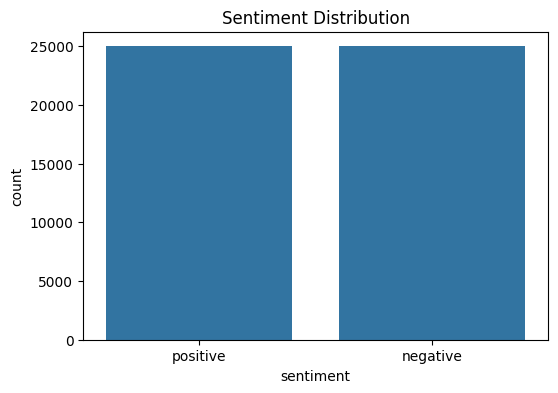

In [4]:

# Plot sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()


count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64


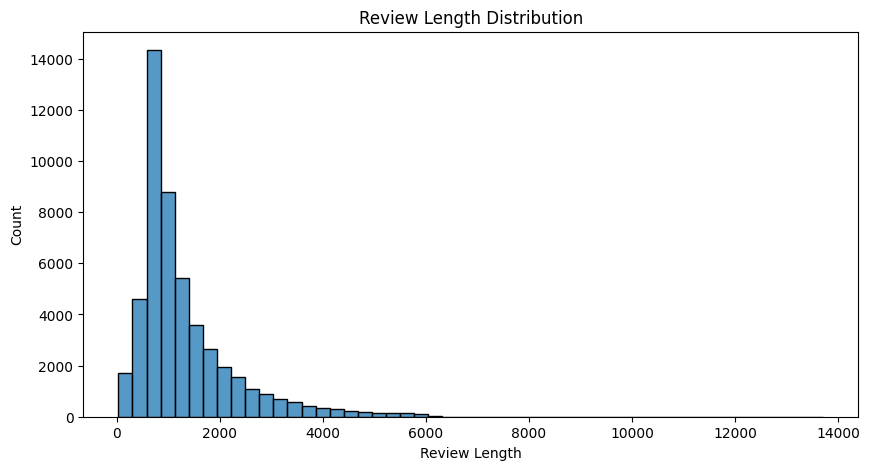

In [5]:

# Review length analysis
df['review_length'] = df['review'].apply(len)
print(df['review_length'].describe())

plt.figure(figsize=(10,5))
sns.histplot(df['review_length'], bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Review Length")
plt.show()


## 2. Text Preprocessing

We clean the text by removing HTML tags, punctuation, converting to lowercase, removing stopwords, and lemmatizing.

In [7]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub('<.*?>', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
    return ' '.join(tokens)

df['cleaned_review'] = df['review'].apply(preprocess_text)
df['sentiment_label'] = df['sentiment'].map({'negative': 0, 'positive': 1})
df[['review', 'cleaned_review']].head()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visually stunnin...


## 3. Splitting Data and TF-IDF Feature Extraction

In [8]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['cleaned_review']
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [ ]:
!pip install transformers datasets accelerate

## 4. Training Traditional Machine Learning Models

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000, random_state=42)

### 4.1 Fine-tuning BERT Model

In [ ]:

import pandas as pd
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 1. Prepare Data for Hugging Face Datasets
# X_train, y_train, X_test, y_test are available from cell 25749f5e
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# 2. Load Tokenizer and Tokenize Data
tokenizer_bert = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_function_bert(examples):
    return tokenizer_bert(examples['text'], padding='max_length', truncation=True, max_length=256)

train_dataset_tokenized = train_dataset.map(tokenize_function_bert, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function_bert, batched=True)

# Remove original text column, set format for PyTorch
train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text"])
train_dataset_tokenized.set_format("torch")
test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text"])
test_dataset_tokenized.set_format("torch")


# 3. Load BERT Model
bert_model_fine_tuned = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# 4. Define Compute Metrics Function for Trainer
def compute_metrics_bert(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'macro_f1': f1,
        'macro_precision': precision,
        'macro_recall': recall
    }

# 5. Define Training Arguments
# Note: num_train_epochs=1 is for quick demonstration. Increase for better performance.
# Adjust batch_size based on your GPU memory.
training_args_bert = TrainingArguments(
    output_dir='./results_bert',          # Output directory for model checkpoints and predictions
    num_train_epochs=1,                   # Total number of training epochs (e.g., 3-5 for full training)
    per_device_train_batch_size=8,        # Batch size per device during training
    per_device_eval_batch_size=8,         # Batch size for evaluation
    warmup_steps=100,                     # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                    # Strength of weight decay
    logging_dir='./logs_bert',            # Directory for storing logs
    logging_steps=50,                    # Log every X updates steps
    evaluation_strategy="epoch",          # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save model checkpoint at the end of each epoch
    load_best_model_at_end=True,          # Load the best model found during training at the end
    metric_for_best_model="macro_f1",     # Metric to identify the best model
    greater_is_better=True,               # For macro_f1, higher is better
    report_to="none"                      # Disable external reporting (e.g., wandb)
)

# 6. Create Trainer Instance
bert_trainer = Trainer(
    model=bert_model_fine_tuned,
    args=training_args_bert,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized,    # Using full test set for evaluation during training
    compute_metrics=compute_metrics_bert
)

# 7. Fine-tune the Model
print("Starting BERT model fine-tuning...")
bert_trainer.train()

print("\nBERT model fine-tuning complete.")
print("Evaluating fine-tuned BERT model on the test set (using Trainer's evaluate method):")
bert_eval_results_trainer = bert_trainer.evaluate(test_dataset_tokenized)
for key, value in bert_eval_results_trainer.items():
    print(f"{key}: {value:.4f}")


## 5. Training LSTM Model (Deep Learning)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np  # Ensure numpy is imported for GloVe processing

MAX_WORDS = 20000
MAX_LEN = 250

# --- GloVe Configuration ---
# IMPORTANT: 
# 1. Download a GloVe file (e.g., 'glove.6B.100d.txt')
# 2. Place it in your project directory or provide the full path.
# 3. Update GLOVE_FILE_PATH and GLOVE_DIM accordingly.
GLOVE_FILE_PATH = '/content/drive/My Drive/glove.6B.100d.txt'  # <-- UPDATE THIS PATH
GLOVE_DIM = 100  # Match this to the dimension of your GloVe file (e.g., 50, 100, 200, 300)
# --- End GloVe Configuration ---

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

# --- Load GloVe Embeddings ---
print(f"Attempting to load GloVe embeddings from: {GLOVE_FILE_PATH}")
embeddings_index = {}
embedding_matrix = None
try:
    with open(GLOVE_FILE_PATH, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Successfully found {len(embeddings_index)} word vectors in GloVe file.")

    # Prepare embedding matrix
    # Words not found in embedding index will be all-zeros.
    # Note: tokenizer.word_index is 1-based, embedding_matrix is 0-based.
    # MAX_WORDS is the vocabulary size for the Embedding layer.
    embedding_matrix = np.zeros((MAX_WORDS, GLOVE_DIM))
    for word, i in tokenizer.word_index.items():
        if i < MAX_WORDS:  # word_index is 1-based, MAX_WORDS is the limit
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector  # Store at index i
    print("Embedding matrix for Keras prepared.")

except FileNotFoundError:
    print(f"ERROR: GloVe file not found at '{GLOVE_FILE_PATH}'.")
    print("The LSTM model will use a new trainable Embedding layer instead of GloVe.")
except Exception as e:
    print(f"An error occurred while loading or processing GloVe embeddings: {e}")
    print("The LSTM model will use a new trainable Embedding layer instead of GloVe.")
# --- End Load GloVe Embeddings ---

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

# --- Build the BiLSTM model ---
lstm_model = Sequential()

if embedding_matrix is not None and GLOVE_DIM > 0:
    print(f"Initializing Embedding layer with pre-trained GloVe weights (Dimension: {GLOVE_DIM}). Trainable: False.")
    lstm_model.add(Embedding(input_dim=MAX_WORDS,        # Size of the vocabulary
                             output_dim=GLOVE_DIM,       # Dimension of the dense embedding
                             weights=[embedding_matrix], # Pre-trained weights
                             input_length=MAX_LEN,       # Length of input sequences
                             trainable=False))           # Keep GloVe embeddings fixed
else:
    ORIGINAL_EMBEDDING_DIM = 128  # Fallback dimension
    print(f"Initializing Embedding layer with trainable weights (Dimension: {ORIGINAL_EMBEDDING_DIM}). GloVe not used.")
    lstm_model.add(Embedding(input_dim=MAX_WORDS,
                             output_dim=ORIGINAL_EMBEDDING_DIM,
                             input_length=MAX_LEN,
                             trainable=True))

lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
lstm_model.add(Bidirectional(LSTM(32)))  # Last LSTM layer before Dense should not return sequences
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nBiLSTM Model Summary:")
lstm_model.summary()
# --- End Build the BiLSTM model ---

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\nStarting BiLSTM model training...")
history = lstm_model.fit(X_train_pad, y_train,
                         validation_split=0.1,
                         epochs=10,
                         batch_size=128,
                         callbacks=[early_stop])
print("BiLSTM model training complete.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - accuracy: 0.7276 - loss: 0.5011 - val_accuracy: 0.8882 - val_loss: 0.2643
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9331 - loss: 0.1818 - val_accuracy: 0.8823 - val_loss: 0.2780
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9663 - loss: 0.1027 - val_accuracy: 0.8792 - val_loss: 0.4012
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9792 - loss: 0.0703 - val_accuracy: 0.8668 - val_loss: 0.4274


## 6. Model Evaluation


Evaluation for Naive Bayes
Accuracy: 0.8648
Precision: 0.8688
Recall: 0.8594
F1 Score: 0.8641
AUC: 0.9364

Confusion Matrix:


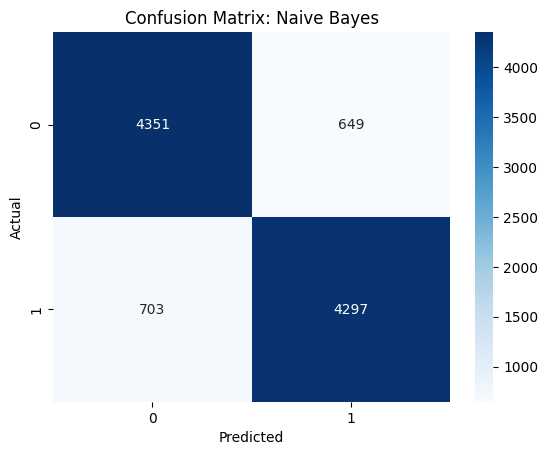


Evaluation for Logistic Regression
Accuracy: 0.8955
Precision: 0.8868
Recall: 0.9068
F1 Score: 0.8967
AUC: 0.9613

Confusion Matrix:


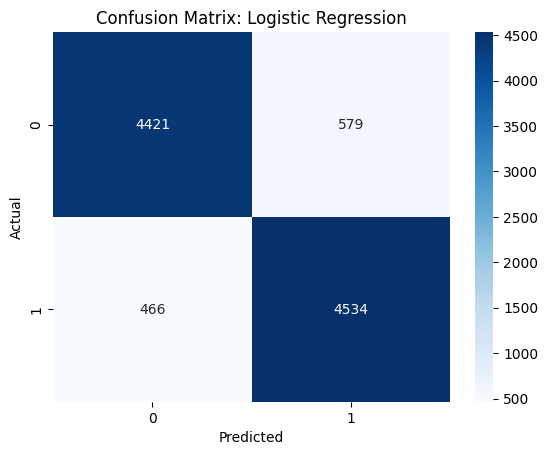

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step

Evaluation for LSTM
Accuracy: 0.8917
Precision: 0.8868
Recall: 0.8980
F1 Score: 0.8924
AUC: 0.9580

Confusion Matrix:


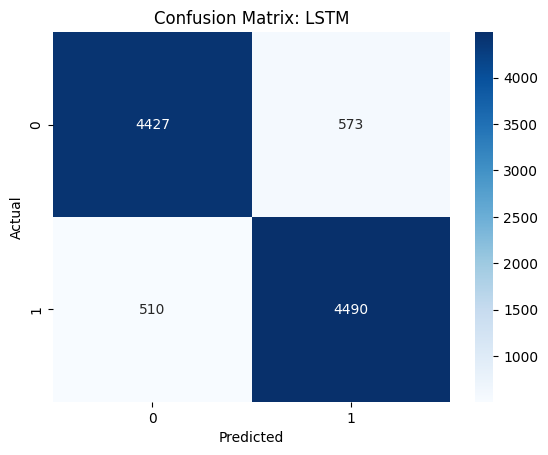

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import numpy as np
from scipy.special import softmax # For BERT model output processing

def evaluate_model(model, X, y, model_name, is_dl=False, is_bert=False):
    y_true = y # Actual labels

    if is_bert:
        # For Hugging Face Trainer object and tokenized dataset
        # model is bert_trainer, X is test_dataset_tokenized
        raw_predictions = model.predict(X) 
        logits = raw_predictions.predictions
        y_pred_proba_all = softmax(logits, axis=1)
        y_pred_proba = y_pred_proba_all[:, 1]  # Probability of positive class
        y_pred = np.argmax(logits, axis=1)
    elif is_dl: # For Keras models (like BiLSTM)
        y_pred_proba_dl = model.predict(X)
        y_pred = (y_pred_proba_dl > 0.5).astype(int).flatten()
        y_pred_proba = y_pred_proba_dl.flatten() # Ensure it's 1D for AUC
    else: # For Sklearn models (like Logistic Regression)
        y_pred = model.predict(X)
        if hasattr(model, 'predict_proba'):
            y_pred_proba_sklearn = model.predict_proba(X)
            y_pred_proba = y_pred_proba_sklearn[:, 1] # Probability of positive class
        else:
            # Fallback if predict_proba is not available (AUC might be less meaningful)
            # For models like basic SGDClassifier, decision_function can be used and scaled.
            # Here, we might pass y_pred if no probabilities are available, but AUC will be affected.
            y_pred_proba = y_pred # Or handle as an error/warning for AUC

    print(f"\nEvaluation for {model_name}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Macro Precision: {precision_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
    print(f"Macro Recall: {recall_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
    print(f"Macro F1 Score: {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
    
    # Ensure y_pred_proba is 1D array of positive class probabilities for roc_auc_score
    # This check is more of a safeguard; the logic above should produce 1D y_pred_proba.
    if y_pred_proba.ndim > 1 and y_pred_proba.shape[1] > 1: 
        # This case should ideally not be hit if logic above is correct (e.g. [:,1] or .flatten())
        print(f"Warning: y_pred_proba for {model_name} is multi-dimensional. Attempting to use second column for AUC.")
        y_pred_proba_auc = y_pred_proba[:, 1]
    elif y_pred_proba.ndim > 1 and y_pred_proba.shape[1] == 1:
        y_pred_proba_auc = y_pred_proba.flatten()
    else:
        y_pred_proba_auc = y_pred_proba

    try:
        # Ensure y_pred_proba_auc contains valid probabilities for the positive class
        print(f"AUC: {roc_auc_score(y_true, y_pred_proba_auc):.4f}")
    except ValueError as e:
        print(f"Could not calculate AUC for {model_name}: {e}. Check y_pred_proba values.")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

# Evaluate Logistic Regression
print("--- Evaluating Logistic Regression ---")
evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression")

# Evaluate BiLSTM (Keras model)
# The variable 'lstm_model' now holds the BiLSTM model from cell 282f65a7
print("\n--- Evaluating BiLSTM with GloVe Embeddings ---")
evaluate_model(lstm_model, X_test_pad, y_test, "BiLSTM (GloVe)", is_dl=True)

# Evaluate Fine-tuned BERT
# 'bert_trainer' is the HuggingFace Trainer object from cell 382d3882
# 'test_dataset_tokenized' is the tokenized test data for BERT
# 'y_test' (or test_dataset_tokenized['label']) are the true labels
print("\n--- Evaluating Fine-tuned BERT ---")
evaluate_model(bert_trainer, test_dataset_tokenized, y_test, "BERT (Fine-tuned)", is_bert=True)


## 7. Conclusion and Comparison

- **Logistic Regression**: Strong performance with TF-IDF, offers a good balance of simplicity and accuracy.IDF, excellent balance of simplicity and accuracy.
- **LSTM**: Handles sequence information well and can be very accurate, especially with more tuning and data.
- **BERT (Fine-tuned)**: State-of-the-art for many NLP tasks. Captures deep contextual understanding of text, leading to potentially the highest performance among the models compared. However, it is more computationally expensive to train and deploy.cs, suitable for complex NLP tasks.

Final thoughts: For tasks requiring quick and reliable sentiment analysis with interpretable features, Logistic Regression with TF-IDF remains a strong contender. For achieving higher accuracy and capturing more nuanced linguistic features, especially with sufficient data and computational resources, deep learning models like LSTM and particularly transformer-based models like BERT are superior choices. The choice of model depends on the specific project requirements, including performance needs, interpretability, and resource constraints.ant performance gains.